In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

Precompiling LuxZygoteExt
        Info Given LuxZygoteExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxZygoteExt
[ Info: Precompiling LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee].


In [ ]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
        Info Given PhasorNetworks was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? PhasorNetworks
[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].


In [3]:
using SciMLSensitivity

In [4]:
solver_args = Dict(:adaptive => false, 
                    :dt => 0.01,
                    :sensealg => InterpolatingAdjoint(; autojacvec=ZygoteVJP()),
                    :save_start => true)

Dict{Symbol, Any} with 4 entries:
  :adaptive   => false
  :sensealg   => InterpolatingAdjoint{0, true, Val{:central}, ZygoteVJP}(Zygote…
  :dt         => 0.01
  :save_start => true

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args,
                    leakage=-0.1)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [7]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [ ]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

# Test FP32

In [12]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), 
                x -> tanh_fast.(x), 
                x -> x, 
                PhasorDense(2 => 128), 
                x -> x,
                PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp (generic function with 1 method)

In [16]:
model, ps, st = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{var"#31#34"}, layer_3::WrappedFunction{var"#32#35"}, layer_4::PhasorDense, layer_5::WrappedFunction{var"#33#36"}, layer_6::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#31), layer_3 = WrappedFunction(#32), layer_4 = PhasorDense((2, 128)), layer_5 = WrappedFunction(#33), layer_6 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
function build_ode_mlp(args, spk_args)
    ode_model = Chain(LayerNorm((2,)),
                x -> tanh_fast.(x),
                x -> phase_to_current(x, spk_args=spk_args, tspan=(0.0, 10.0)),
                PhasorDense(2 => 128, return_solution=true),
                x -> mean_phase(x, 1, spk_args=spk_args, offset=0.0),
                PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return ode_model, ps, st
end

build_ode_mlp (generic function with 1 method)

In [14]:
ode_model, ps_ode, st_ode = build_ode_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{true, 1, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon}, layer_2::WrappedFunction{var"#37#40"}, layer_3::WrappedFunction{var"#38#41"{SpikingArgs}}, layer_4::PhasorDense, layer_5::WrappedFunction{var"#39#42"{SpikingArgs}}, layer_6::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#37), layer_3 = WrappedFunction(#38), layer_4 = PhasorDense((2, 128)), layer_5 = WrappedFunction(#39), layer_6 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.

In [37]:
ode_correlation(model, ode_model, ps, st,x, y)

[ Info: Running ODE correlation test...


LoadError: InterruptException:

In [17]:
y_f, _ = model(x, ps, st)

([-0.6651708082762501 0.7266042257523996 … -0.6087355587134147 -0.7949937979975277; -0.9843878580406235 -0.9901886781461985 … -0.9737118934101554 -0.9897830655694276], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

In [19]:
ps |> keys

(:layer_1, :layer_2, :layer_3, :layer_4, :layer_5, :layer_6)

In [20]:
y_ode, _ = ode_model(x, ps, st)

([-0.6529551107569815 0.7326347899864036 … -0.6005183598112145 -0.7923180215565397; -0.9850573388493675 -0.9899994519061961 … -0.9727544857996442 -0.989844695674348], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple(), layer_6 = NamedTuple()))

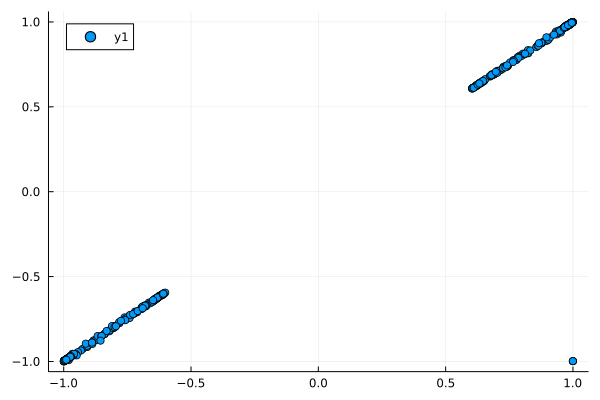

In [21]:
scatter(vec(y_f), vec(y_ode))

In [22]:
cor_realvals(vec(y_f), vec(y_ode))

0.9846813334010819

In [23]:
y_ode

2×256 Matrix{Float64}:
 -0.652955   0.732635  -0.631437  …  -0.798249  -0.600518  -0.792318
 -0.985057  -0.989999  -0.994396     -0.992843  -0.972754  -0.989845

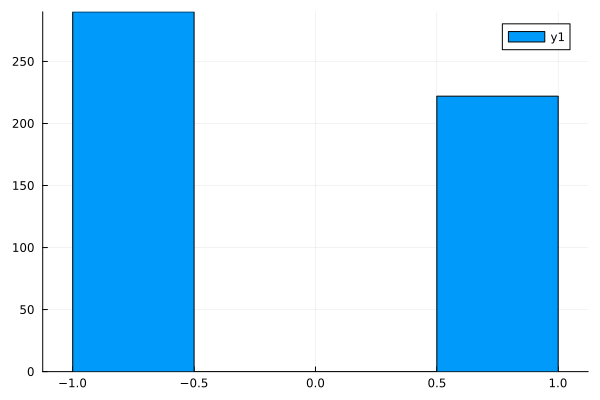

In [24]:
histogram(vec(y_ode))

In [25]:
mean(abs.(y_ode))

0.8665265015128121

In [26]:
psf = ComponentArray(ps_ode)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.12666641 -0.120561965 … -0.12208452 -0.13078421; -0.04557358 -0.05778698 … -0.0043423125 0.09756272], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [27]:
val_ode, grads_ode = withgradient(p -> mean(quadrature_loss(ode_model(x, p, st_ode)[1], y)), psf)

(val = 0.5005514966179582, grad = ((layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[0.0; 0.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.00192183 0.012352879; -0.005537894 -0.014187465; … ; -0.0010668389 -0.010219539; -0.0061196242 -0.017692752], bias_real = Float32[-0.00011116002, -0.001458623, -0.0010334993, -0.0002465598, -2.8541068f-5, 7.613261f-5, -0.00068400276, 0.0033522628, 0.00014696072, 0.0034902564  …  -0.0036504539, -0.002830008, -0.00010251501, -0.0006536981, 0.00019463207, -0.00056018407, -0.00025904656, -0.00063622487, -0.00014093709, -0.0005916806], bias_imag = Float32[-0.05953849, 0.078560546, 0.06756623, -0.034552835, -0.011020039, -0.076472774, 0.044807993, -0.15952247, -0.09374333, -0.12278284  …  0.08969027, 0.05491074, 0.022483837, -0.092513554, -0.03890762, -0.08403788, 0.116426505, -0.04885326, 0.059850395, 0.06886065]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.0016876489 -0.01424531 … -0.0031519306 -0.005940629

In [28]:
val, grads = withgradient(p -> mean(quadrature_loss(model(x, p, st_ode)[1], y)), psf)

(val = 0.4987207307506702, grad = ((layer_1 = (bias = Float32[0.17175497; -0.040389635;;], scale = Float32[-0.00864821; 0.0021709786;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.0015307422 0.011307915; -0.0043997685 -0.012548795; … ; -0.00065161067 -0.009107614; -0.0051002256 -0.016323192], bias_real = Float32[-9.608692f-5, -0.00130152, -0.0008788455, -0.00021879791, 0.00011046191, 0.0002317583, -0.0006498147, 0.0028317198, 0.00012292236, 0.0031986004  …  -0.003252529, -0.0026080504, -7.269283f-5, -0.00044390073, 0.00016559122, -0.00053362135, -0.00018999999, -0.00045481758, -0.00017402417, -0.00041734183], bias_imag = Float32[-0.060389522, 0.07913915, 0.06782098, -0.035104007, -0.01093489, -0.07724923, 0.045659736, -0.1607483, -0.09438405, -0.12403202  …  0.090146974, 0.055486064, 0.02232687, -0.09302268, -0.03913658, -0.08501713, 0.11771684, -0.04911462, 0.06074772, 0.06951381]), layer_5 = Float32[], layer_6 = (weight = Float32[-0.0027981594 -0.0140609

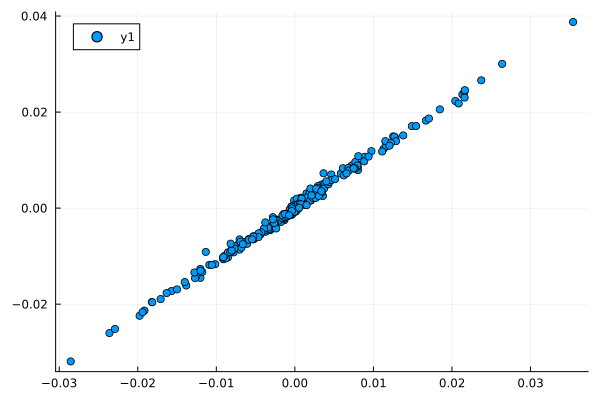

In [29]:
scatter(vec(grads[1].layer_4.weight), vec(grads_ode[1].layer_4.weight))

In [30]:
cor_realvals(vec(grads[1].layer_4.weight), vec(grads_ode[1].layer_4.weight))

0.9973616f0

In [31]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[1.470610285835948, 1.2797578581432816, 1.2667509824545118, 1.1044226741976566, 1.0937309365409635, 1.070293620060026, 1.1034585878486642, 1.1315326869613376, 1.0096109471075247, 1.081606272780796  …  0.10250371031574979, 0.06884748192157294, 0.06350119359570362, 0.07024072672082649, 0.08902531930604576, 0.07827954976032266, 0.08402883979838839, 0.08358139183162153, 0.09079564953722642, 0.07497625157008622], (layer_1 = (bias = Float32[-0.19127946; -0.012986892;;], scale = Float32[0.8404681; 0.9021617;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.3027374 0.07465308; -0.09378023 -0.13670401; … ; -0.020455208 -0.012457536; 0.029322494 0.003102203], bias_real = Float32[0.9619752, 1.0007766, 1.0180982, 1.0119642, 1.0205826, 0.9423916, 0.97089803, 0.9752761, 1.0076125, 1.008484  …  1.0029157, 1.0008974, 1.0031078, 1.0313046, 1.0126935, 1.0050039, 0.9916778, 0.9582613, 1.0252, 0.9983308], bias_imag = Float32[0.07851386, -0.028444134, -0.007862561, -0.0

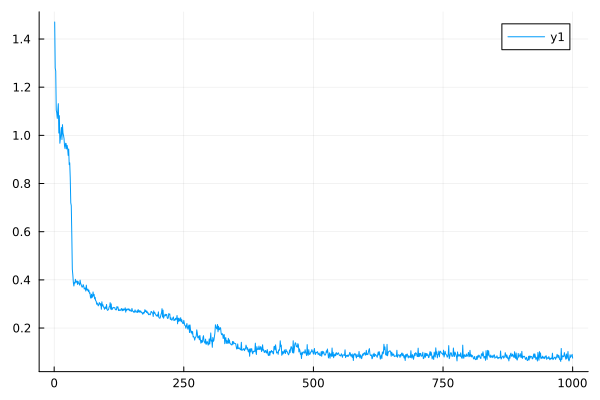

In [32]:
plot(losses)

In [33]:
losses[end]

0.07497625157008622

In [34]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.07724078951642868, 0.952734375)

In [35]:
psf = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = Float32[], layer_3 = Float32[], layer_4 = (weight = Float32[0.27116936 0.0861502; -0.07204794 -0.15312071; … ; -0.039547402 -0.030699156; 0.003936669 -0.020530548], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = Float32[], layer_6 = (weight = Float32[0.022885242 -0.20376815 … 0.006069808 0.04844268; 0.22680388 0.0039727697 … -0.09966416 -0.19447207], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0]))

In [36]:
losses_ode, ps_train_ode, st_train_ode = train(ode_model, psf, st, train_loader, args, verbose = true)

[ Info: Training on CPU


Epoch 1 loss: 1.471670614760603
Epoch 1 loss: 1.2797755869866716
Epoch 1 loss: 1.267028676294693
Epoch 1 loss: 1.104271345598783
Epoch 1 loss: 1.0964540977271757
Epoch 1 loss: 1.074113602965645
Epoch 1 loss: 1.108689217230584
Epoch 1 loss: 1.1376543798198642
Epoch 1 loss: 1.0144064490196423
Epoch 1 loss: 1.0880532231313498
Epoch 1 loss: 0.9719947171674937
Epoch 1 loss: 0.9929546981781718
Epoch 1 loss: 1.0112800536023048
Epoch 1 loss: 1.0392624209832433
Epoch 1 loss: 0.9886868709969514
Epoch 1 loss: 1.0512093379505238


LoadError: InterruptException:

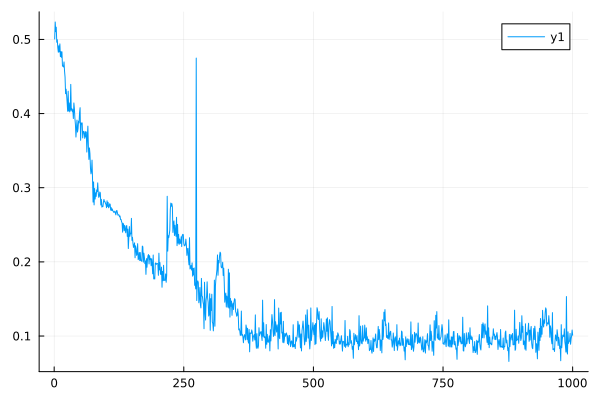

In [ ]:
plot(losses_ode)

In [ ]:
loss_and_accuracy(test_loader, ode_model, ps_train_ode, st_train_ode)

(0.1108247329922166, 0.96640625)